In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import yfinance as yf


# Historical data for NASDAQ and NSE indices.   



In [43]:
nse_ticker = yf.download("^NSEI", start = "2010-01-01" , end = "2023-05-01")
nas_ticker = yf.download("^IXIC", start = "2010-01-01" , end = "2023-05-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [48]:
data_nifty = pd.DataFrame(nse_ticker);
data_nifty['Date'] = data_nifty.index
data_nasdaq = pd.DataFrame(nas_ticker);
data_nasdaq['Date'] = data_nasdaq.index

# CO-RELATION COEFFICIENTS

In [45]:
close_df = pd.DataFrame({'NSE': data_nifty['Close'] , 'Nasdaq': data_nasdaq['Close']})
c = close_df.corr()
corr_coff = c.loc['NSE', 'Nasdaq']
corr_coff

0.9513138758576779

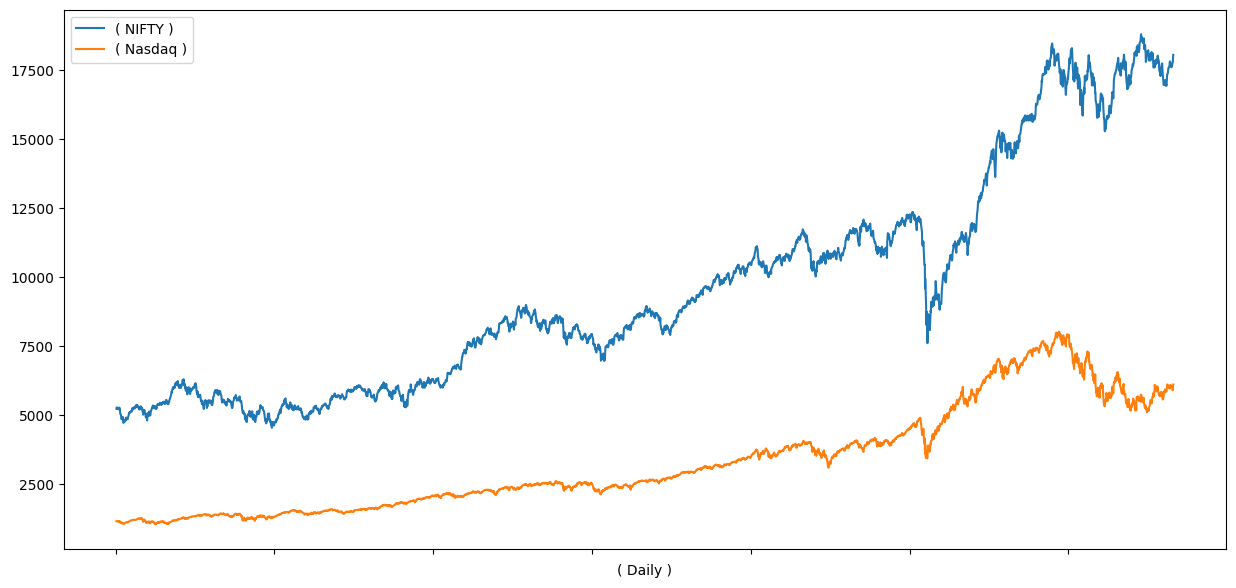

In [33]:
plt.figure(figsize=(15,7))
plt.plot(data_nifty["Date"], data_nifty["Close"], label="( NIFTY )")
plt.plot(data_nasdaq["Date"], 0.50*data_nasdaq["Close"], label="( Nasdaq )")
plt.xlabel('( Daily )')
plt.legend(loc='best')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.show()

# LEAD LAG RELATION

6535
6620


ValueError: could not broadcast input array from shape (6620,) into shape (6535,)

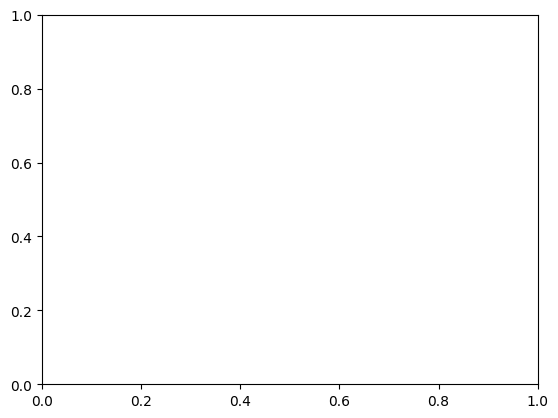

In [34]:
cross_cor = np.correlate(data_nifty['Close'], data_nasdaq['Close'], mode='full')
max_cor_lag = np.argmax(cross_cor) - (len(data_nifty) - 1)
average_period = max_cor_lag / len(data_nifty)
lags = np.arange(-len(data_nifty) + 1, len(data_nifty))
print(len(lags))
print(len(cross_cor))
plt.stem(lags, cross_cor)
plt.xlabel('( Lag )')
plt.ylabel('( Cross-correlation )')
plt.show()

print(f"lag period: {average_period}")

#  KELTNER CHANNELS

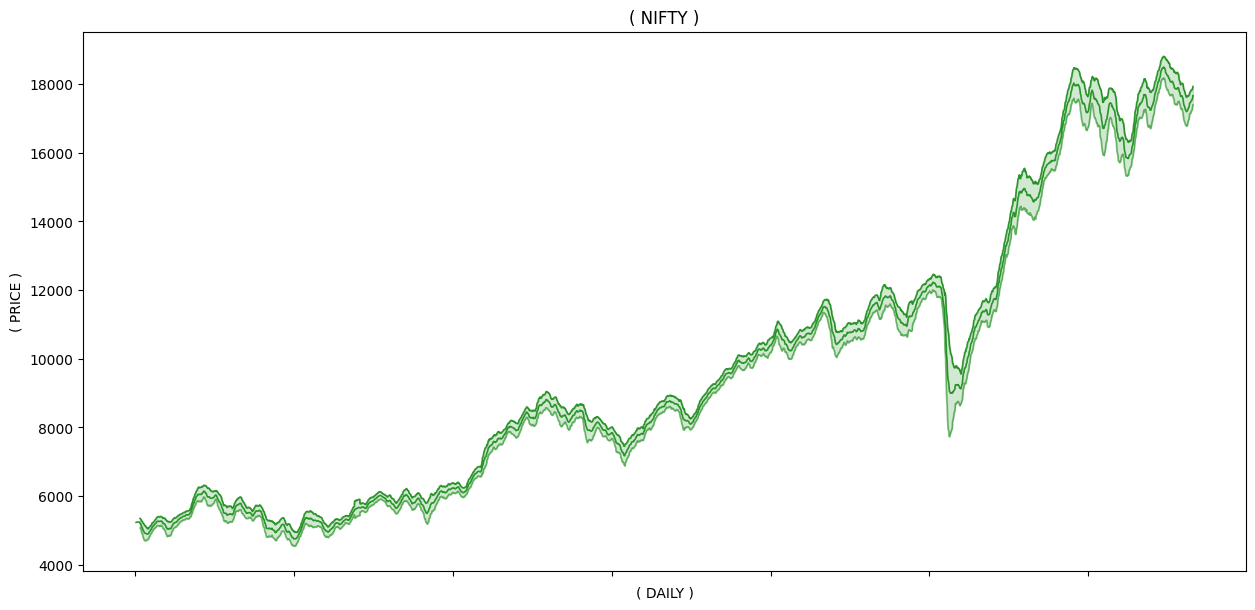

In [49]:
def calculate_ema(dataframe):
    ema = dataframe['Close'].ewm(span=20, adjust=False).mean()
    return ema

def calculate_atr(data):
    # True Range 
    data['HL'] = data['High'] - data['Low']
    data['HC'] = abs(data['High'] - data['Close'].shift(1))
    data['LC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['HL', 'HC', 'LC']].max(axis=1)

    # Average True Range 
    data['ATR'] = data['TR'].rolling(15).mean()

    return data['ATR']

data = data_nifty

date = data["Date"]
ema = calculate_ema(data)
atr = calculate_atr(data)

plt.figure(figsize=(15,7))
plt.plot(date, ema, color='green', linewidth=1.2, alpha=0.8)
plt.plot(date, ema-(2*atr), color='green', linewidth=1.2, alpha=0.5)
plt.plot(date, ema+(2*atr), color='green', linewidth=1.2, alpha=0.8)
plt.fill_between(date, ema-(2*atr), ema+(2*atr), color='green', alpha=0.18)

plt.title('( NIFTY )')
plt.ylabel('( PRICE )')
plt.xlabel('( DAILY )')
plt.plot([], [], ' ')

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.show()

# BOLLINGER BANDS

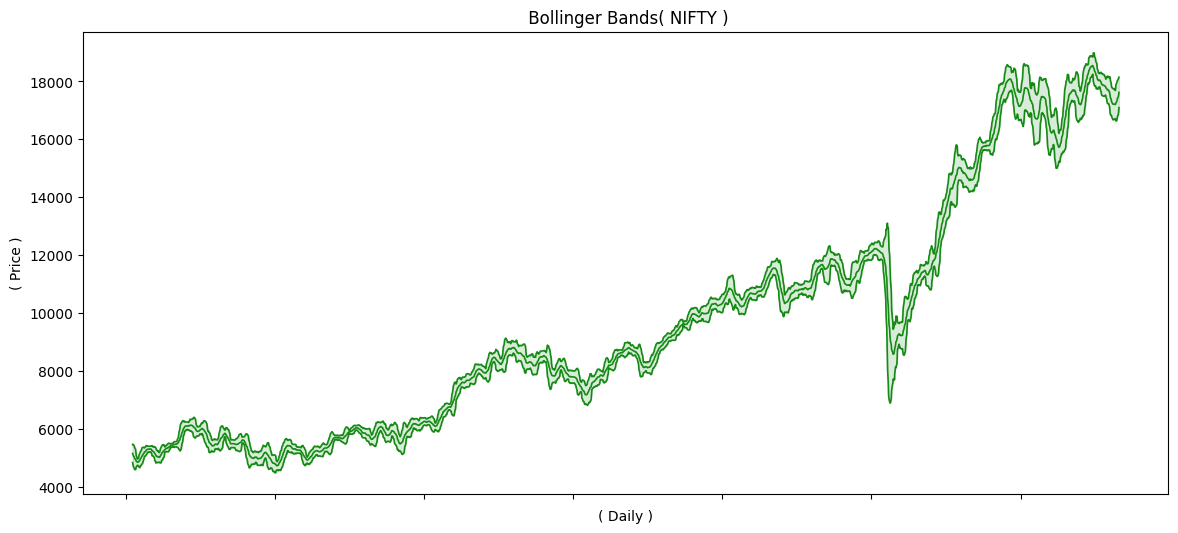

In [50]:
def calculate_bollinger_bands(data):
    rolling_mean = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()

    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)

    return rolling_mean, upper_band, lower_band

data = data_nifty
date = data_nifty["Date"]
rolling_mean, upper_band, lower_band = calculate_bollinger_bands(data)

plt.figure(figsize=(14,6))
plt.plot(date, rolling_mean, color='green', linewidth=1.2, alpha=0.9)
plt.plot(date, upper_band, color='green', linewidth=1.2, alpha=0.9)
plt.plot(date, lower_band, color='green', linewidth=1.2, alpha=0.9)
plt.fill_between(date, lower_band, upper_band, color='green', alpha=0.15)
plt.title(' Bollinger Bands( NIFTY )')
plt.ylabel('( Price )')
plt.xlabel('( Daily )')
plt.plot([], [], ' ', label='2x Std Dev ')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.show()

#  MACD

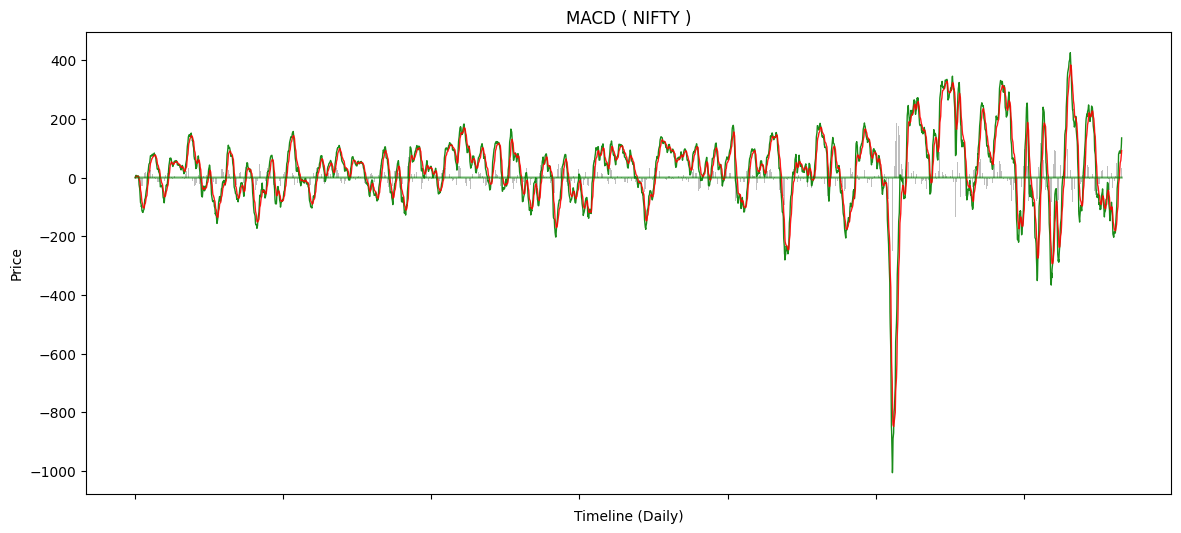

In [51]:
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = data['Close'].ewm(span=short_period, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_period, adjust=False).mean()
    
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_histogram = macd_line - signal_line
    
    return macd_line, signal_line, macd_histogram

data = data_nifty

macd_line, signal_line, macd_histogram = calculate_macd(data, 12, 26, 9)

plt.figure(figsize=(14,6))
plt.plot(date, macd_line, label='MACD', color='green', alpha=0.9, linewidth=1.0)
plt.plot(date, signal_line, label='Signal', color='red', alpha=0.9, linewidth=1.0)
zeros = np.zeros(len(data))
plt.plot(date, zeros, color='green', alpha=0.6)
plt.bar(date, macd_histogram, color='black', alpha=0.25)

plt.title('MACD ( NIFTY )')
plt.ylabel('Price')
plt.xlabel('Timeline (Daily)')
plt.plot([], [], ' ', label='12, 26, 9')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.show()

Signal Generation


if ( Signal line cross MACD from above ) & ( MA26 > MA12 ) => BUY Signal

if ( Signal line cross MACD from below ) & ( MA26 < MA12 ) => SELL Signal



In [ ]:
def macd_buy_or_sell(data):
    position = None
    returns = []


    for i in range(1, len(data)):

        if data['MACD Line'].iloc[i] > data['Signal Line'].iloc[i]:
            if position is None:
                position = 'buy'

        elif data['MACD Line'].iloc[i] < data['Signal Line'].iloc[i]:
            if position == 'buy':
                position = None
                returns.append(data['Close'].iloc[i] / data['Close'].iloc[i-1] - 1)

    return returns

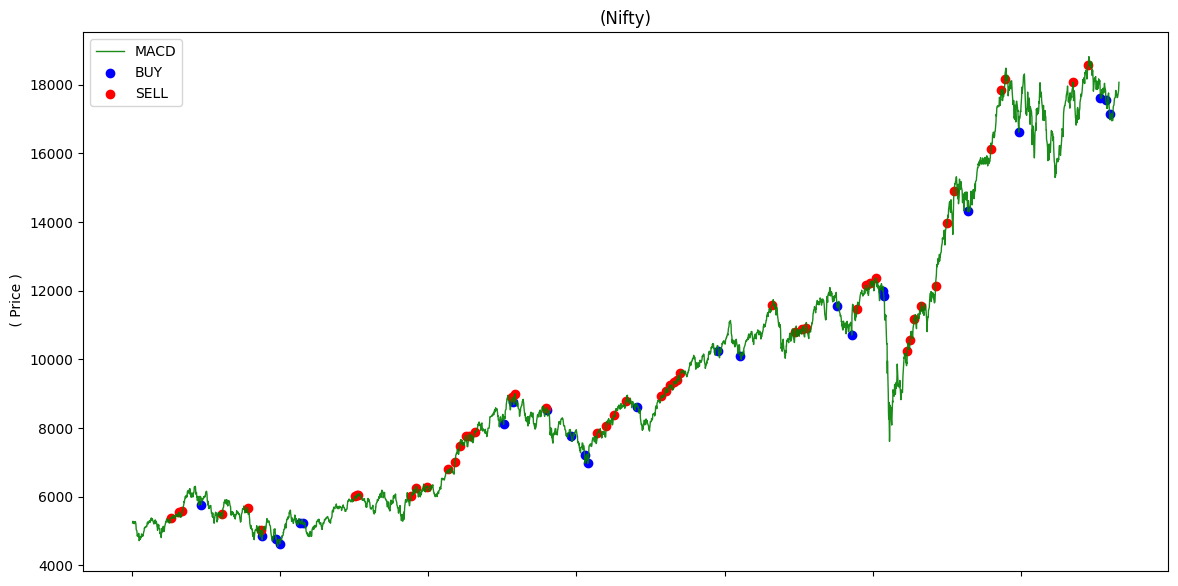

In [55]:
data = data_nifty
date = data['Date']
ema = calculate_ema(data)
atr = calculate_atr(data)
rolling_mean, upper_band, lower_band = calculate_bollinger_bands(data)
macd_line, signal_line, macd_histogram = calculate_macd(data, 12, 26, 9)

def detect_crossover(data, a, b):
    ma_l = data['Close'].rolling(window=26).mean()
    ma_s = data['Close'].rolling(window=12).mean()

    p_cross = []
    n_cross = []
    p_cross.append(None)
    n_cross.append(None)

    for i in range(1, len(a)):
        if (a[i-1] < b[i-1]) and (a[i] >= b[i]):
            if(ma_l[i] > ma_s[i]):
                p_cross.append(data['Close'][i])
            else:
                p_cross.append(None)
            n_cross.append(None)
        elif (a[i-1] > b[i-1]) and (a[i] <= b[i]):
            p_cross.append(None)
            if(ma_l[i] < ma_s[i]):
                n_cross.append(data['Close'][i])
            else:
                n_cross.append(None)
        else :
            p_cross.append(None)
            n_cross.append(None)

    return p_cross, n_cross

macd_pc, macd_nc = detect_crossover(data, signal_line, macd_line)


plt.figure(figsize=(14,7))
plt.plot(date, data['Close'], label='MACD', color='green', alpha=0.9, linewidth=1.0)
plt.title('(Nifty)')
plt.ylabel(' ( Price )')
plt.xlabel('( Daily )')
plt.scatter(date, macd_pc, color='blue', label='BUY')
plt.scatter(date, macd_nc, color='red', label='SELL')
plt.legend(loc='best')
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])

plt.show()

In [59]:
#sharpe ratio
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

In [60]:
#Cumulutive Returns
def cumulative_returns(df):
    
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod()
    
    df['percent_cumulative_return'] = ( df['Cumulative Return'] - 1) * 100
    
    return df['percent_cumulative_return']

In [61]:
#maximum drawdown
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

# NET PROFIT/LOSS

In [57]:
buy_sell = {'Buying Date':[], 'Buying Price':[], 'Selling Date':[], 'Selling Price':[]}
for i in range(0, len(date)):
    if(macd_pc[i] != None):
        buy_sell['Buying Date'].append(date[i])
        buy_sell['Buying Price'].append(macd_pc[i])    
    else:
        buy_sell['Buying Date'].append(None)
        buy_sell['Buying Price'].append(None)     
    if(macd_nc[i] != None):
        buy_sell['Selling Date'].append(date[i])
        buy_sell['Selling Price'].append(macd_nc[i])   
    else: 
        buy_sell['Selling Date'].append(None)
        buy_sell['Selling Price'].append(None)

buy_sell = pd.DataFrame(buy_sell)
sell = buy_sell['Selling Price']
buy = buy_sell['Buying Price']
netpl = sell-buy
buy_sell['Net profit/loss'] = netpl
print(buy_sell)
cumm_return = sum(netpl)
print('\n\t\t\tCUMULATIVE RETURNS = ', '{0:.2f}'.format(cumm_return))
print('\n\t\t\tSHARPE RATIO = ', '{0:.2f}'.format(stats.mean(netpl)/stats.stdev(netpl)))

     Buying Date  Buying Price Selling Date  Selling Price  Net profit/loss
0            NaT           NaN          NaT            NaN              NaN
1            NaT           NaN          NaT            NaN              NaN
2            NaT           NaN          NaT            NaN              NaN
3            NaT           NaN          NaT            NaN              NaN
4            NaT           NaN          NaT            NaN              NaN
...          ...           ...          ...            ...              ...
3263         NaT           NaN          NaT            NaN              NaN
3264         NaT           NaN          NaT            NaN              NaN
3265         NaT           NaN          NaT            NaN              NaN
3266         NaT           NaN          NaT            NaN              NaN
3267         NaT           NaN          NaT            NaN              NaN

[3268 rows x 5 columns]

			CUMULATIVE RETURNS =  nan


ValueError: cannot convert NaN to integer ratio